In [1]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
# Define file paths and names
folder_path_train = "..\\data\\intermediary\\train"
folder_path_test = "..\\data\\intermediary\\test"
names = ["Facebook", "Reddit", "Twitter", "Youtube"]

# Load datasets
dfs_train = {n: pd.read_csv(os.path.join(folder_path_train, f"cleaned_{n.lower()}_train.csv")) for n in names}
dfs_test = {n: pd.read_csv(os.path.join(folder_path_test, f"cleaned_{n.lower()}_test.csv")) for n in names}

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Define stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vital\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vital\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
for name in names:
    dfs_train[name]['processed_text'] = dfs_train[name]['text'].apply(preprocess_text)
    dfs_test[name]['processed_text'] = dfs_test[name]['text'].apply(preprocess_text)
    dfs_train[name]['label'] = dfs_train[name]['label'].astype(int)
    dfs_test[name]['label'] = dfs_test[name]['label'].astype(int)

In [4]:
tfidf_vectorizers = {name: TfidfVectorizer() for name in names}
for name in names:
    tfidf_vectorizers[name].fit(dfs_train[name]['processed_text'])
    dfs_train[name]['embedding'] = list(tfidf_vectorizers[name].transform(dfs_train[name]['processed_text']).toarray())
    dfs_test[name]['embedding'] = list(tfidf_vectorizers[name].transform(dfs_test[name]['processed_text']).toarray())


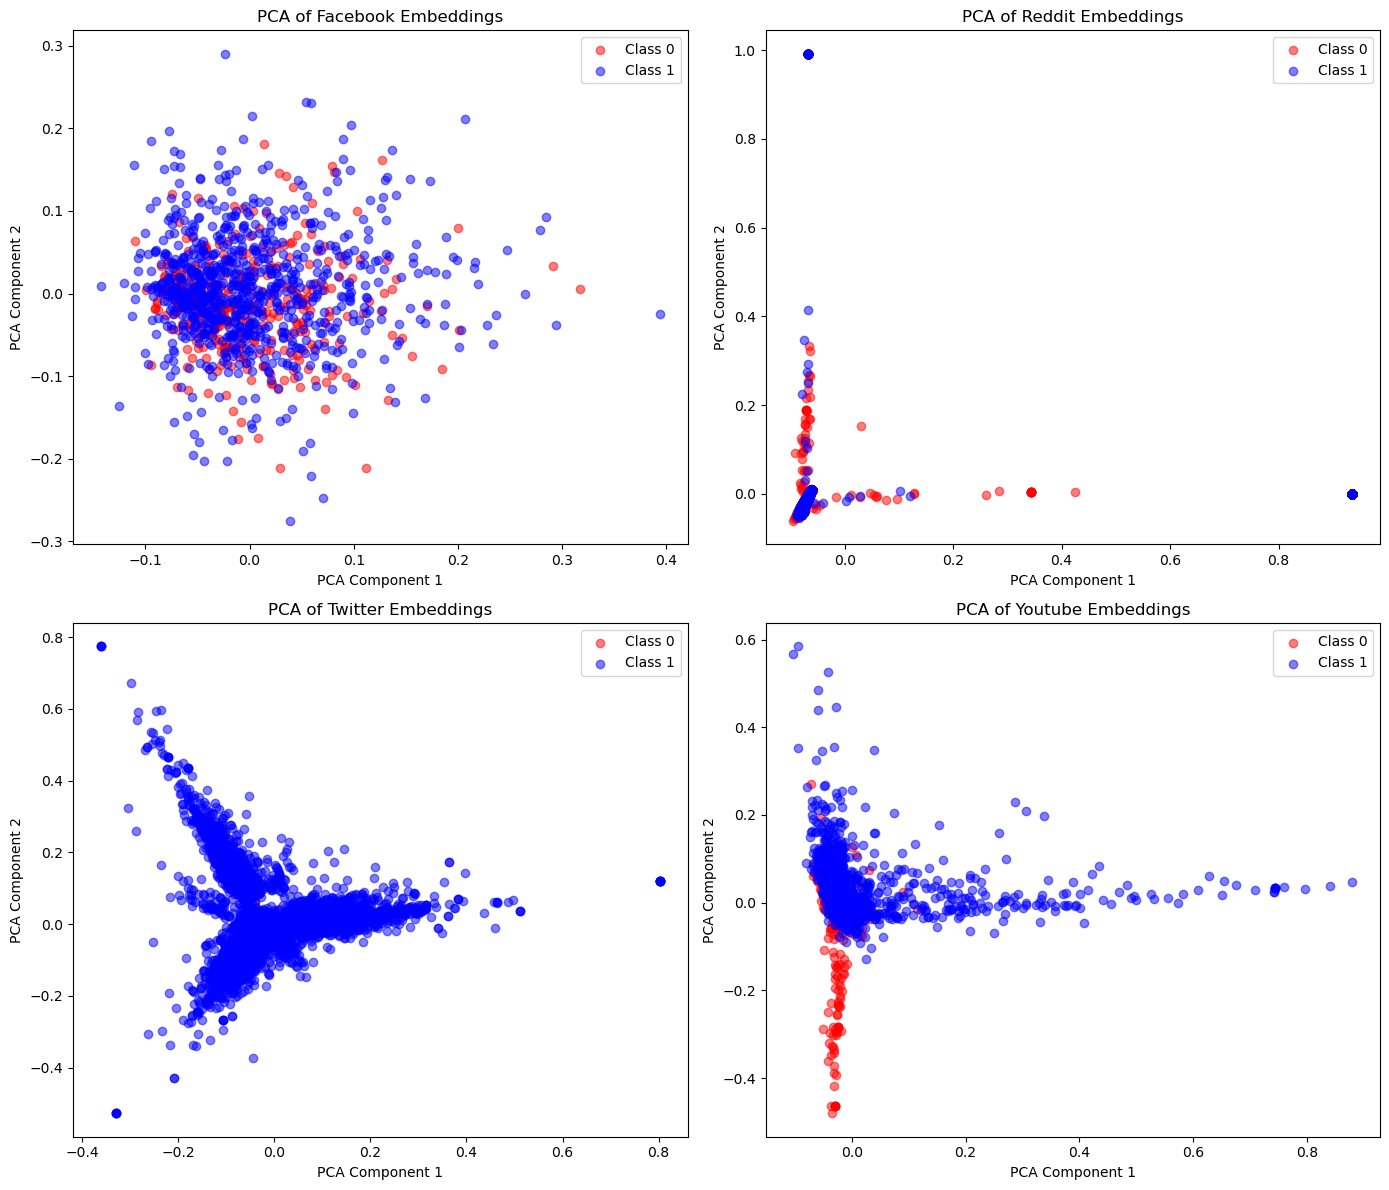

In [5]:
# Plot embeddings for each dataset using PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

fig, axs = plt.subplots(2, 2, figsize=(14, 12))

for ax, name in zip(axs.flatten(), names):
    pca = PCA(n_components=2)
    embeddings = np.vstack(dfs_train[name]['embedding'].values)
    labels = dfs_train[name]['label'].values
    reduced_embeddings = pca.fit_transform(embeddings)
    
    ax.scatter(reduced_embeddings[labels == 0, 0], reduced_embeddings[labels == 0, 1], c='red', label='Class 0', alpha=0.5)
    ax.scatter(reduced_embeddings[labels == 1, 0], reduced_embeddings[labels == 1, 1], c='blue', label='Class 1', alpha=0.5)
    ax.set_title(f'PCA of {name} Embeddings')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.legend()

plt.tight_layout()
plt.show()

In [7]:
pca = PCA(n_components=500)
results = []
for name in names:
    X_train = np.vstack(dfs_train[name]['embedding'].values)
    y_train = dfs_train[name]['label']
    
    X_test = np.vstack(dfs_test[name]['embedding'].values)
    y_test = dfs_test[name]['label']
    
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    classifier = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)  # Use fewer trees and all available cores
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Collect results for each class
    for cls in ['0', '1']:
        results.append({
            'Dataset': name,
            'Class': cls,
            'Precision': report[cls]['precision'],
            'Recall': report[cls]['recall'],
            'F1-Score': report[cls]['f1-score'],
            'Accuracy': np.nan  # Accuracy is not class-specific
        })
    
    # Include the overall metrics for the dataset
    results.append({
        'Dataset': name,
        'Class': 'overall',
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Accuracy': accuracy
    })

results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df)

c:\Development\python_conda\envs\data-science\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
